# HSQL v2 calculation

This notebook calculates HQSL for Santiago's project using as base data document:
* __*'High Quality Societal Life Methodological guidelines'*__ from Chaire ETI (Entrepreneuriat Territoire Innovation) of IAE Parise Sorbonne Business School.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm 

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Config notebook

In [3]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = True
# How to save?
if_exists='append'
# save to local?
save_local = False
# use local data?
local_data = False
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [4]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 9
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [5]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

## __Load data__

### __Load data__ - Pois proximity (regular and unique ID pois)

In [6]:
area_dict = {'unidadesvecinales':'COD_UNICO_',
            'zonascensales':'GEOCODI',  
            'alameda':'name',
            'comunas':'Comuna',
            'hex':'hex_id', # 
            'santiago':'nom_region'} #

In [7]:
area_analysis = 'hex' # unidadesvecinales, zonascensales, alameda, comunas
code_column = area_dict[area_analysis] # COD_UNICO_ - GEOCODI , name, Comuna

In [8]:
if local_data:
    if area_analysis == 'hexagon':
        prox_gdf = gpd.read_file(grl_dir + f'santiago_hexproximity_{speed_name}_kmh_res{res}.gpkg')
    elif area_analysis == 'alameda':
        prox_gdf = gpd.read_file(grl_dir + f'santiago_alamedaproximity_{speed_name}_kmh.gpkg')
else:
    if area_analysis == 'hex':
        query = f'SELECT * FROM projects_research.santiago_hexproximity_{speed_name}_kmh WHERE res = {res}'
        prox_gdf = aup.gdf_from_query(query)
    elif area_analysis == 'unidadesvecinales':
        prox_gdf = aup.gdf_from_db(f'santiago_unidadesvecinalesproximity_{speed_name}_kmh','projects_research')

    elif area_analysis == 'zonascensales':
        prox_gdf = aup.gdf_from_db(f'santiago_zonascensalesproximity_{speed_name}_kmh','projects_research')
    
    elif area_analysis == 'comunas':
        prox_gdf = aup.gdf_from_db(f'santiago_comunasproximity_{speed_name}_kmh','projects_research')
    
    elif area_analysis == 'santiago':
        prox_gdf = aup.gdf_from_db(f'santiago_{area_analysis}proximity_{speed_name}_kmh','projects_research')
    

prox_gdf = prox_gdf.rename(columns={'paradas_tp_count_15min':'paradas_tp_ruta_count_15min',
                                   'paradas_tp_time':'paradas_tp_ruta_time'})
# Show
print(prox_gdf.shape)
prox_gdf.head(1)

(210519, 120)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,estaciones_bicicletas_time,estaciones_bicicletas_count_15min,res,city
0,8ab2c0b00007fff,"POLYGON ((-71.00842 -33.71206, -71.00905 -33.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,Santiago


### __Load data__ - Specific analysis (hex_areal)

In [9]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    hex_dir = f"../../../data/processed/santiago/areal_data/{area_analysis}_areal_res{res}.gpkg"
elif all_local_dirs == 'edgar':
    if area_analysis == 'hex':
        hex_dir = f'../../../data/processed/00_pois_formated/aereal_data/{area_analysis}_areal_res{res}.gpkg'
    else:
        hex_dir = f'../../../data/processed/00_pois_formated/aereal_data/{area_analysis}_areal.gpkg'
        
hex_areal = gpd.read_file(hex_dir)
hex_areal = hex_areal.rename(columns={'oficinas_sum':'oficinas_count',
                                     'pct_social_viv':'social_viv_count',
                                     'viv_sum':'houses_count',
                                     'pct_hotel':'hotel_count',
                                     'ndvi_mean':'ndvi_count'})

# Show
print(hex_areal.shape)
hex_areal.head(1)

(63913, 10)


,hex_id,oficinas_count,hotel_count,social_viv_count,houses_count,temp_count,inter_count,noise_count,ndvi_count,geometry
0,8ab2c5540647fff,0.911951,0.190803,0.0,39.760461,-0.45121,66.0,58.392857,0.135445,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4..."


In [10]:
hex_areal.oficinas_count.mean()

0.9590961386590661

## Data treatment

### Data treatment -- join pois

In [11]:
join_pois_list = ['hospital','clinica','consult_ado', 'museos',
                 'vacunatorio','eq_deportivo',]

for source in join_pois_list:
    # join count columns for private and public in one encompassing column
    prox_gdf[f"{source}_count_15min"] = prox_gdf[f"{source}_priv_count_15min"] + prox_gdf[f"{source}_pub_count_15min"]
    # remove 0 values from time
    prox_gdf.loc[prox_gdf[f"{source}_pub_time"]==0] = np.nan
    prox_gdf.loc[prox_gdf[f"{source}_priv_time"]==0] = np.nan
    # assign general minimum time
    prox_gdf[f"{source}_time"] = prox_gdf[[f"{source}_pub_time", f"{source}_priv_time"]].min(axis=1)
    # remove duplicate info columns
    prox_gdf = prox_gdf.drop(columns=[f"{source}_pub_count_15min", f"{source}_priv_count_15min",
                                     f"{source}_pub_time", f"{source}_priv_time"])
    # fill na with 0 for future processing
    prox_gdf['hospital_time'].fillna(0, inplace=True)

### Data treatment -- merge hexagons

In [12]:
hex_analysis = hex_areal.merge(prox_gdf.drop(columns='geometry'), on=code_column, how='left')
print(hex_analysis.shape)
hex_analysis.head(3)

(63913, 116)


,hex_id,oficinas_count,hotel_count,social_viv_count,houses_count,temp_count,inter_count,noise_count,ndvi_count,geometry,...,clinica_count_15min,clinica_time,consult_ado_count_15min,consult_ado_time,museos_count_15min,museos_time,vacunatorio_count_15min,vacunatorio_time,eq_deportivo_count_15min,eq_deportivo_time
0,8ab2c5540647fff,0.911951,0.190803,0.0,39.760461,-0.451210,66.000000,58.392857,0.135445,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",...,4.0,6.049196,3.0,2.641548,8.0,6.346424,0.0,49.638147,3.0,11.741114
1,8ab2c546b0cffff,0.000000,0.000000,0.0,0.000000,-0.396870,3.000000,52.500000,0.287743,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8ab2c519838ffff,0.000000,0.000000,0.0,11.562370,-2.133381,136.111111,64.531250,0.231218,"POLYGON ((-70.54047 -33.41159, -70.54110 -33.4...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
hex_analysis = hex_analysis.explode(ignore_index=True)
hex_analysis = hex_analysis.dissolve(by=code_column)
hex_analysis = hex_analysis.reset_index()

In [14]:
hex_analysis.shape

(63913, 116)

### Data treatment -- filter missing times

In [15]:
# hex_analysis = hex_analysis.loc[hex_analysis.supermercado_time>0].copy()
# print(hex_analysis.shape)
# hex_analysis.head(3)

<AxesSubplot: >

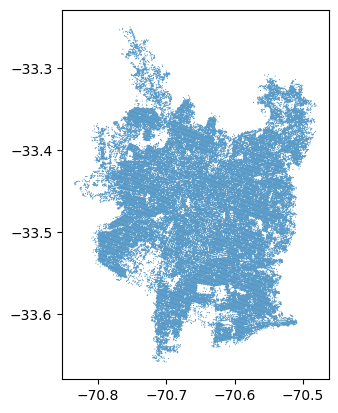

In [16]:
hex_analysis.dropna().plot()

## HQSL Function

### Variables dict

In [17]:
# --- REQUIRED DATA: parameters dictionary [AS OF 2024 06 28]
# Structure: {social_functions:{themes:[source_names]}}
parameters_dict = {'supplying':{'wellbeing':['carniceria', #Accessibility to Butcher/Fish Shops
                                             'hogar', #Accessibility to Hardware/Paint Shops
                                             #Not available: Accessibility to Greengrocers
                                             'bakeries', #Accessibility to Bakeries and delis
                                             'supermercado',#Accessibility to supermarkets
                                             'banco'#Accessibility to bank
                                            ],
                                'sociability':['ferias',#Accessibility to city fairs/markets
                                               'local_mini_market',#Accessibility to local and mini markets
                                               'correos'#ADDED: MAIL SERVICE
                                              ],
                                'environmental_impact':['centro_recyc'#Accessibility to recycling center
                                                        #Not available: Accessibility to compost
                                                       ]
                               },
                   'caring':{'wellbeing':['hospital', #Accessibility to hospital
                                          'clinica',#Accessibility to public clinics
                                          'farmacia',#Accessibility to pharmacies
                                          'vacunatorio',#Accessibility to vaccination center
                                          'consult_ado',#Accessibility to optician/audiologist(###ADDED DENTIST)
                                          'salud_mental',###ADDED: MENTAL HEALTH
                                          'labs_priv',###ADDED: LABORATORIES
                                          'residencia_adumayor'###ADDED: ELDERLY PERMANENT RESIDENCIES
                                         ],
                             'sociability':['eq_deportivo',#Accessibility to sports equipments
                                            'club_deportivo'#Accessibility to sport clubs
                                           ],
                             'environmental_impact':['noise',
                                                     'temp'
                                 #Not available: Air polution
                                                    ]
                            },
                   'living':{'wellbeing':['civic_office',#Accessibility to civic offices
                                          #Not available: Number of street bentches
                                          'tax_collection',#ADDED: AFIP(TAX COLLECTOR)
                                          'social_security',#ADDED: SOCIAL SECURITY
                                          'police',#Accessibility to police(###MOVED FROM LIVING TO CARING)
                                          'bomberos'#Accessibility to fire stations
                                          #Not available: Accessibility to street lamp
                                         ],
                             'sociability':['houses',#Accessibility to permanent residencies
                                            'social_viv',#Accessibility to social housing
                                            #Not available: Accessibility to student housing
                                            'hotel'#ADDED: HOTELS
                                           ],
                             'environmental_impact':['inter',
                                                     #Not available: Corrected compactness
                                                     #Not available: Width of sidewalks
                                                    ],
                            },
                   'enjoying':{'wellbeing':['museos',#Accessibility to museums
                                            #Not available: Accessibility to theater,operas
                                            'cines',#Accessibility to cinemas
                                            'sitios_historicos',#Accessibility to historical places
                                            'ndvi'#Number of trees
                                           ],
                               'sociability':['restaurantes_bar_cafe',#Accessibility to bars/cafes + Accessibility to restaurants
                                              'librerias',#Accessibility to record and book stores, galleries, fairs
                                              #Not available: Accessibility to cultural and/or formative spaces
                                              #Not available: Accessibility to places of workship
                                              'ep_plaza_small'#Accessibility to boulevards, linear parks, small squares + Accessibility to squares
                                             ],
                               'environmental_impact':['ep_plaza_big'#Accessibility to big parks
                                                       #Not available: Accessibility to shared gardens
                                                       #Not available: Accessibility to urban playgrounds
                                                      ]
                              },
                   'learning':{'wellbeing':['edu_basica_pub',#'edu_basica_priv',#Accessibility to public elementary school
                                            'edu_media_pub',#'edu_media_priv',#Accessibility to public high school
                                            'jardin_inf_pub',#'jardin_inf_priv',#Similar to Accessibility to childcare
                                            'universidad',#Accessibility to university
                                            'edu_tecnica',#ADDED: TECHNICAL EDUCATION
                                           ],
                               'sociability':['edu_adultos_pub',#'edu_adultos_priv',#Accessibility to adult formation centers
                                              'edu_especial_pub',#'edu_especial_priv',#Accessibility to specialized educational centers
                                              #Not available: Accesibility to establishments and services for disabled adults
                                              'bibliotecas'#Accessibility to libraries(###MOVED FROM ENJOYING TO LEARNING)
                                             ],
                               'environmental_impact':['centro_edu_amb'#Accessibility to centers for learning environmental activities
                                                       #Not available: Accessibility to gardening schools
                                                      ],
                              },
                   'working':{'wellbeing':['paradas_tp_ruta',#Accessibility to bus stop
                                           'paradas_tp_metro',#Accessibility to metro
                                           'paradas_tp_tren'#Accessibility to train stop
                                          ],
                              'sociability':['oficinas'#Accessibility to office
                                             #Not available: Accessibility to incubators
                                             #Not available: AccSeveral other articles cite 60dB as a safe noise zone. essibility to coworking places
                                          ],
                              
                              'environmental_impact':['ciclovias',
                                                      'estaciones_bicicletas'#Accessibility to bike lanes
                                                      #Not available: Accessibility to shared bike stations
                                                     ]
                             }
                  }

weight_dict = {'carniceria':'rare', #SUPPLYING
               'hogar':'rare',
               'bakeries':'rare',
               'supermercado':'rare',
               'banco':'rare',
               'ferias':'rare',
               'local_mini_market':'rare',
               'correos':'very_rare',
               'centro_recyc':'rare',
               #CARING
               'hospital':'very_rare',
               'clinica':'rare',
               'farmacia':'rare',
               'vacunatorio':'very_rare',
               'consult_ado':'very_rare',
               'salud_mental':'very_rare',
               'labs_priv':'very_rare',
               'residencia_adumayor':'rare',
               'eq_deportivo':'rare',
               'club_deportivo':'rare',
               'noise':'specific',
               'temp':'specific',
               #LIVING
               'civic_office':'rare', 
               'tax_collection':'very_rare',
               'social_security':'very_rare',
               'police':'very_rare',
               'bomberos':'very_rare',
               'houses':'specific',
               'social_viv':'specific',
               'hotel':'rare',
               'inter':'specific',
               #ENJOYING
               'museos':'very_rare',
               'cines':'very_rare',
               'sitios_historicos':'rare',
               'ndvi':'specific',
               'restaurantes_bar_cafe':'frequent',
               'librerias':'rare',
               'ep_plaza_small':'frequent',
               'ep_plaza_big':'rare',
               #LEARNING
               'edu_basica_pub':'rare', 
               'edu_media_pub':'rare',
               'jardin_inf_pub':'rare',
               'universidad':'very_rare',
               'edu_tecnica':'very_rare',
               'edu_adultos_pub':'rare',
               'edu_especial_pub':'rare',
               'bibliotecas':'very_rare',
               'centro_edu_amb':'very_rare',
               #WORKING
               'paradas_tp_ruta':'frequent',
               'paradas_tp_metro':'rare',
               'paradas_tp_tren':'very_rare',
               'oficinas':'specific',
               'ciclovias':'rare',
               'estaciones_bicicletas':'rare',
              }

<AxesSubplot: >

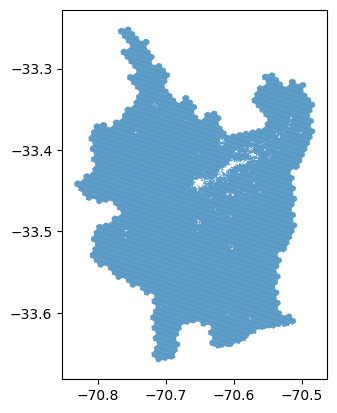

In [18]:
hex_analysis.loc[hex_analysis.oficinas_count<16.63].plot()

### Scale functions

In [19]:
def rare_fn(cont):
    if cont == 0:
        res_val = 0
    elif cont > 0 and cont < 2:
        res_val = res_val_regression(0, 2, 0, 2.5, cont)
    elif cont >= 2 and cont < 4:
        res_val = res_val_regression(2, 4, 2.5, 5, cont)
    elif cont >= 4 and cont < 7:
        res_val = res_val_regression(4, 7, 5, 7.5, cont)
    elif cont >= 7 and cont < 10:
        res_val = res_val_regression(7, 10, 7.5, 10, cont)
    elif cont >= 10:
        res_val = 10
    
    return res_val

def very_rare_fn(cont):
    min_x = 0
    max_x = 1
    min_y = 0
    max_y = 10
    return res_val_regression(min_x, max_x, min_y, max_y, cont)

def frequent_fn(cont):
    if cont == 0:
        res_val = 0
    elif cont > 0 and cont < 6:
        res_val = res_val_regression(0, 6, 0, 2.5, cont)
    elif cont >= 6 and cont < 12:
        res_val = res_val_regression(6, 12, 2.5, 5, cont)
    elif cont >= 12 and cont < 18:
        res_val = res_val_regression(12, 18, 5, 7.5, cont)
    elif cont >= 18 and cont < 25:
        res_val = res_val_regression(18, 25, 7.5, 10, cont)
    elif cont >= 25:
        res_val = 10
    
    return res_val


def res_val_regression(min_x, max_x, min_y, max_y, cont):
    slope = (max_y-min_y)/(max_x-min_x)
    
    intersect = min_y - slope * min_x
    
    res_val = slope * cont + intersect
    
    if cont > max_x:
        res_val = max_y
        
    return res_val

def office_fn(cont):
    if cont == 0:
        res_val = 0
    elif cont > 0 and cont < 2.823938308:
        res_val = res_val_regression(0, 2.823938308, 0, 2.5, cont)
    elif cont >= 2.823938308 and cont <  5.539263604:
        res_val = res_val_regression(2.823938308, 5.539263604, 2.5, 5, cont)
    elif cont >= 5.539263604 and cont < 10.96991420:
        res_val = res_val_regression(5.539263604, 10.96991420, 5, 7.5, cont)
    elif cont >= 10.96991420 and cont < 16.40056479:
        res_val = res_val_regression(10.96991420, 16.40056479, 7.5, 10, cont)
    elif cont >= 16.40056479:
        res_val = 10
    
    return res_val


def ndvi_fn(cont):
    min_x = 0
    max_x = 0.4
    min_y = 0
    max_y = 10
    if cont > max_x:
        return 10
    elif cont <= min_x:
        return 0
    else:
        return res_val_regression(min_x, max_x, min_y, max_y, cont)

def inter_fn(cont):
    min_x = 20
    max_x = 100
    min_y = 0
    max_y = 10
    if cont > max_x:
        return 10
    elif cont < min_x:
        return 0
    else:
        return res_val_regression(min_x, max_x, min_y, max_y, cont)

def noise_fn(cont):
    min_x = 55
    max_x = 70
    min_y = 10
    max_y = 0
    if cont > max_x:
        return 0
    elif cont < min_x:
        return 10
    else:
        return res_val_regression(min_x, max_x, min_y, max_y, cont)

def temp_fn(cont, mean, std):
    if cont >= (mean + 2*std):
        res_val = 0
        
    elif cont < (mean + 2*std) and cont >= (mean + std):
        res_val = res_val_regression((mean + std), (mean + 2*std), 2.5, 0, cont)
        
    elif cont < (mean + std) and cont >= (mean):
        res_val = res_val_regression((mean), (mean + std), 5, 2.5, cont)
        
    elif cont < (mean) and cont >= (mean - std):
        res_val = res_val_regression((mean - std), (mean), 7.5, 5, cont)
        
    elif cont < (mean - std) and cont >= (mean - 2*std):
        res_val = res_val_regression((mean - 2*std), (mean - std), 10, 7.5, cont)
    
    elif cont < (mean - 2*std):
        res_val = 10

    if area_analysis == 'santiago':
        res_val = 5
    
    return res_val

def household_fn(cont):
    res_val = res_val_regression(0, 50, 0, 10, cont)
    return res_val

def social_viv_fn(cont):
    min_x = 0
    max_x = 20
    min_y = 0
    max_y = 10
    if cont > max_x:
        return 10
    elif cont < min_x:
        return 0
    else:
        return res_val_regression(min_x, max_x, min_y, max_y, cont)

def specific_fn(cont, source, mean, std):
    if 'ndvi' in source:
        return ndvi_fn(cont)
    elif 'inter' in source:
        return inter_fn(cont)
    elif 'noise' in source:
        return noise_fn(cont)
    elif 'temp' in source:
        return temp_fn(cont, mean, std)
    elif 'houses' in source:
        return household_fn(cont)
    elif 'social_viv' in source:
        return social_viv_fn(cont)
    elif 'oficinas' in source:
        return office_fn(cont)

def scale_source_fn(cont, source, weight_dict, mean, std):
    if weight_dict[source] == 'rare':
        return rare_fn(cont)
    elif weight_dict[source] == 'very_rare':
        return very_rare_fn(cont)
    elif weight_dict[source] == 'frequent':
        return frequent_fn(cont)
    elif weight_dict[source] == 'specific':
        return specific_fn(cont, source, mean, std)

### Function test

In [20]:
cont_test =0
print('frequent:',frequent_fn(cont_test), 'rare:',rare_fn(cont_test), 'very_rare:',very_rare_fn(cont_test))

frequent: 0 rare: 0 very_rare: 0.0


In [21]:
for i in range(0,30,1):
    cont_test = i + 0.5
    print('cont:',cont_test,'frequent:',round(frequent_fn(cont_test),2), 'rare:',rare_fn(cont_test), 'very_rare:',very_rare_fn(cont_test))

cont: 0.5 frequent: 0.21 rare: 0.625 very_rare: 5.0
cont: 1.5 frequent: 0.62 rare: 1.875 very_rare: 10
cont: 2.5 frequent: 1.04 rare: 3.125 very_rare: 10
cont: 3.5 frequent: 1.46 rare: 4.375 very_rare: 10
cont: 4.5 frequent: 1.88 rare: 5.416666666666666 very_rare: 10
cont: 5.5 frequent: 2.29 rare: 6.25 very_rare: 10
cont: 6.5 frequent: 2.71 rare: 7.083333333333334 very_rare: 10
cont: 7.5 frequent: 3.12 rare: 7.916666666666666 very_rare: 10
cont: 8.5 frequent: 3.54 rare: 8.75 very_rare: 10
cont: 9.5 frequent: 3.96 rare: 9.583333333333332 very_rare: 10
cont: 10.5 frequent: 4.38 rare: 10 very_rare: 10
cont: 11.5 frequent: 4.79 rare: 10 very_rare: 10
cont: 12.5 frequent: 5.21 rare: 10 very_rare: 10
cont: 13.5 frequent: 5.62 rare: 10 very_rare: 10
cont: 14.5 frequent: 6.04 rare: 10 very_rare: 10
cont: 15.5 frequent: 6.46 rare: 10 very_rare: 10
cont: 16.5 frequent: 6.88 rare: 10 very_rare: 10
cont: 17.5 frequent: 7.29 rare: 10 very_rare: 10
cont: 18.5 frequent: 7.68 rare: 10 very_rare: 10
co

In [22]:
temp_fn(-6,0,3)

10.0

## Scale data

In [36]:
# use scale functions for eacgh column
for i in tqdm(range(len(weight_dict.keys())),position=0,leave=True):
    # gather specific source
    source = list(weight_dict.keys())[i]
    # print(source)
    # iterate over columns
    for col_name in hex_analysis.columns:
        # select column with count information -- refers to the amount of opportunities available at 15 min
        if source in col_name and 'count' in col_name:
            if f'{source}_time' in hex_analysis.columns:
                hex_analysis[f'{source}_time'].fillna(0, inplace=True)
            hex_analysis[col_name].fillna(0, inplace=True)
            # source scaling
            hex_analysis[f'{source}_scaled'] = hex_analysis[col_name].apply(lambda x:
                                                                            scale_source_fn(
                                                                                x,
                                                                            source,
                                                                                weight_dict, 
                                                                hex_analysis[col_name].mean(),
                                                                hex_analysis[col_name].std()))
            # treat 0 time values -- hexagons without nodes 
            if area_analysis == 'hex':
                if weight_dict[source] != 'specific':
                    # assign nan values to hexagons without nodes to avoid affecting the mean calculation process
                    #if source in join_pois_list:
                    #    hex_analysis.loc[hex_analysis.supermercado_time==0,f'{source}_scaled'] = np.nan
                    if source == 'hotel' or source == 'oficinas':
                        continue
                    else:
                        hex_analysis.loc[hex_analysis[f'{source}_time']==0,f'{source}_scaled'] = np.nan
                        
                    # calculate mean count value
                    # print(source)
                    hex_analysis.loc[hex_analysis[f'{source}_time']==0, f'{source}_scaled'] = hex_analysis.loc[hex_analysis[f'{source}_time']==0].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_analysis,
                                                                            f'{source}_scaled'), axis=1)

print(hex_analysis.shape)
hex_analysis.head(4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [1:57:28<00:00, 133.00s/it]

(63913, 169)


,hex_id,geometry,oficinas_count,hotel_count,social_viv_count,houses_count,temp_count,inter_count,noise_count,ndvi_count,...,edu_adultos_pub_scaled,edu_especial_pub_scaled,bibliotecas_scaled,centro_edu_amb_scaled,paradas_tp_ruta_scaled,paradas_tp_metro_scaled,paradas_tp_tren_scaled,oficinas_scaled,ciclovias_scaled,estaciones_bicicletas_scaled
0,8ab2c5080007fff,"POLYGON ((-70.53068 -33.49576, -70.53131 -33.4...",0.0,0.0,0.0,6.415616,-3.693681,17.916667,64.0,0.285407,...,0.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8ab2c508000ffff,"POLYGON ((-70.52987 -33.49656, -70.53050 -33.4...",0.0,0.0,0.0,6.948466,-4.458022,25.633333,60.0,0.274801,...,0.0,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8ab2c5080017fff,"POLYGON ((-70.53203 -33.49599, -70.53266 -33.4...",0.0,0.0,0.0,8.355073,-4.074874,16.526316,60.0,0.318273,...,0.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8ab2c508001ffff,"POLYGON ((-70.53122 -33.49679, -70.53185 -33.4...",0.0,0.0,0.0,4.847219,-4.059824,22.965517,64.0,0.346917,...,0.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: xlabel='ep_plaza_big_scaled', ylabel='Count'>

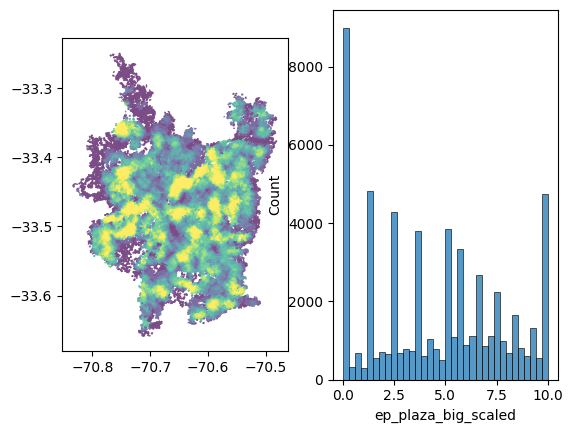

In [53]:
fig,ax = plt.subplots(1,2)

plot_variable = 'ep_plaza_big'
plot_variable_name = f'{plot_variable}_scaled'

hex_analysis.plot(plot_variable_name, ax=ax[0])
sns.histplot(hex_analysis, x=plot_variable_name, ax=ax[1])

In [41]:
hex_analysis.dropna().shape

(44700, 169)

### Upload data

In [54]:
upload_preprocessed = True

if upload_preprocessed:
    hex_preprocessed = hex_analysis.copy()
    if area_analysis == 'hex':
        hex_preprocessed['res'] = res
    hex_preprocessed = hex_preprocessed.dropna()
    table = f'santiago_{area_analysis}variableanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    aup.gdf_to_db_slow(hex_preprocessed, table, schema, if_exists=if_exists)
    del hex_preprocessed

### Index functions

In [55]:
def hqsl_fn(hex_gdf, parameters_dict):

    hex_gdf = hex_gdf.copy()
    
    social_function_list = []
    
    for social_function in parameters_dict.keys():
        social_function_list.append(social_function)
    
    hex_gdf['hqsl'] = hex_gdf[social_function_list].sum(axis=1)

    base_columns = [code_column,'geometry']
    filter_list = ['hqsl']
    filter_list.extend(base_columns)
    hex_gdf = hex_gdf[filter_list].copy()
    
    return hex_gdf

def social_fn(hex_gdf, parameters_dict):
    
    hex_gdf = hex_gdf.copy()
    
    for social_function in parameters_dict.keys():
        source_list = []
        
        for indicator in parameters_dict[social_function].keys():
            source_list.extend(parameters_dict[social_function][indicator])
        
        source_list = [s+'_scaled' for s in source_list]
        hex_gdf[social_function] = hex_gdf[source_list].mean(axis=1)

    base_columns = [code_column,'geometry']
    filter_list = list(parameters_dict.keys())
    filter_list.extend(base_columns)
    hex_gdf = hex_gdf[filter_list].copy()
    
    return hex_gdf

def indicator_fn(hex_gdf, parameters_dict):
    hex_ind = hex_analysis.copy()

    filter_list = []
    
    indicator_list = list(set().union(*parameters_dict.values()))
    for indicator in indicator_list:
        social_indicator = []
        
        for social_function in parameters_dict.keys():
            social_indicator.append(indicator+'_'+social_function)
            
            source_indicator = parameters_dict[social_function][indicator]
            source_indicator = [s+'_scaled' for s in source_indicator]
            
            hex_ind[indicator+'_'+social_function] = hex_ind[source_indicator].mean(axis=1)
    
        hex_ind[indicator] = hex_ind[social_indicator].sum(axis=1)
        filter_list.extend(social_indicator)
        filter_list.append(indicator)
    
    base_columns = [code_column,'geometry']
    filter_list.extend(base_columns)
    hex_ind = hex_ind[filter_list].copy()
            
    return hex_ind


## Calculate index

In [56]:
hex_ind = indicator_fn(hex_analysis, parameters_dict)
hex_social_fn = social_fn(hex_analysis, parameters_dict)
hex_hqsl = hqsl_fn(hex_social_fn, parameters_dict)

In [57]:
hex_idx = hex_ind.merge(hex_social_fn.drop(columns='geometry'), on=code_column)
hex_idx = hex_idx.merge(hex_hqsl.drop(columns='geometry'), on=code_column)
print(hex_idx.shape)
hex_idx.head(5)

(63913, 30)


,sociability_supplying,sociability_caring,sociability_living,sociability_enjoying,sociability_learning,sociability_working,sociability,environmental_impact_supplying,environmental_impact_caring,environmental_impact_living,...,wellbeing,hex_id,geometry,supplying,caring,living,enjoying,learning,working,hqsl
0,0.000000,0.0,0.427708,1.041667,0.833333,0.000000,2.302708,0.0,6.073411,0.000000,...,1.783794,8ab2c5080007fff,"POLYGON ((-70.53068 -33.49576, -70.53131 -33.4...",0.000000,1.012235,0.142569,1.595022,0.277778,0.00000,3.027604
1,0.000000,0.0,0.463231,1.111111,0.416667,0.000000,1.991009,0.0,7.785811,0.704167,...,1.717506,8ab2c508000ffff,"POLYGON ((-70.52987 -33.49656, -70.53050 -33.4...",0.000000,1.297635,0.232651,1.587920,0.138889,0.00000,3.257095
2,0.000000,0.0,0.557005,0.370370,0.833333,0.000000,1.760709,0.0,7.595792,0.000000,...,1.989206,8ab2c5080017fff,"POLYGON ((-70.53203 -33.49599, -70.53266 -33.4...",0.000000,1.265965,0.185668,1.341825,0.277778,0.00000,3.071237
3,0.000000,0.0,0.323148,0.763889,0.833333,0.000000,1.920370,0.0,6.254995,0.370690,...,2.168234,8ab2c508001ffff,"POLYGON ((-70.53122 -33.49679, -70.53185 -33.4...",0.000000,1.042499,0.148904,1.683075,0.277778,0.00000,3.152256
4,0.416667,0.0,0.231928,1.805556,0.833333,0.001959,3.289443,0.0,5.257994,0.000000,...,2.014155,8ab2c5080027fff,"POLYGON ((-70.53014 -33.49474, -70.53077 -33.4...",0.277778,0.876332,0.077309,2.027911,0.277778,0.20866,3.745768


In [58]:
hex_idx.columns

Index(['sociability_supplying', 'sociability_caring', 'sociability_living',
       'sociability_enjoying', 'sociability_learning', 'sociability_working',
       'sociability', 'environmental_impact_supplying',
       'environmental_impact_caring', 'environmental_impact_living',
       'environmental_impact_enjoying', 'environmental_impact_learning',
       'environmental_impact_working', 'environmental_impact',
       'wellbeing_supplying', 'wellbeing_caring', 'wellbeing_living',
       'wellbeing_enjoying', 'wellbeing_learning', 'wellbeing_working',
       'wellbeing', 'hex_id', 'geometry', 'supplying', 'caring', 'living',
       'enjoying', 'learning', 'working', 'hqsl'],
      dtype='object')

## Plot results

<AxesSubplot: xlabel='enjoying', ylabel='Count'>

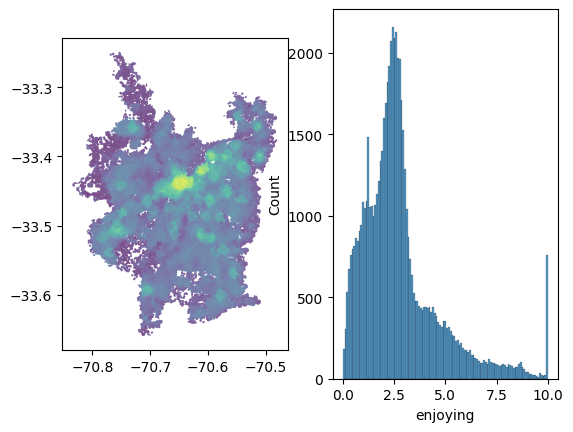

In [64]:
fig,ax = plt.subplots(1,2)

plot_variable_name = 'enjoying'

hex_idx.dropna().plot(plot_variable_name, ax=ax[0])
sns.histplot(hex_idx, x=plot_variable_name, ax=ax[1])

In [60]:
hex_idx.dropna().learning.mean()

1.6205692122933766

In [61]:
hex_idx.dropna().hqsl.mean()

12.088458380713432

## Upload data

In [65]:
if area_analysis == 'hex':
    hex_idx['res'] = res

hex_idx = hex_idx.dropna()

if save:
    table = f'santiago_{area_analysis}analysis_{speed_name}_kmh'
    schema = 'projects_research'
    aup.gdf_to_db_slow(hex_idx, table, schema, if_exists=if_exists)
if save_local:
    hex_idx.to_file(grl_dir + f'santiago_{area_analysis}analysis_{speed_name}_kmh.geojson')